Function that computes all powers

In [287]:
from perfetto.trace_processor import TraceProcessor
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

def get_powers(num_tps,df_list_cleaned,scale):
#     plt.rcParams['figure.figsize'] = [13, 10]
    initial_offset = 2
#     color_list = ['green','teal','salmon','salmon','salmon','salmon','salmon','salmon','salmon','salmon','salmon','salmon']
#     legend_list = ['','','Modem','RFE','','','','','','','','','','Display']

    battery_power = []
    battery_mean_pwr = []
    battery_charge = []
    delta_battery = []


    for tp_idx in range(num_tps):
        df_np = np.array(df_list_cleaned[tp_idx])
        df_np[:,:,0] = df_np[:,:,0] - np.tile(df_np[:,0,0],[df_np.shape[1],1]).T
        df_np[:,:,0] = df_np[:,:,0]/1e9
        sum_pwr = [0]*len(df_np[1,:,1])
#         plt.subplot(num_tps,1,tp_idx+1)
        for i in range(4):
            x_vals = df_np[i,:,0]
            y_vals = df_np[i,:,1]
            delta_x_vals = np.copy(x_vals)
            delta_x_vals[1:] = delta_x_vals[1:]-delta_x_vals[0:x_vals.size-1]
            delta_x_vals[0] = 0
            delta_y_vals = np.copy(y_vals)
            if (i==0) : #reads battery charge
#                 print(y_vals)
                delta_y_vals = 3.7*10**(-3)*((y_vals[0]-y_vals[-1])/(len(y_vals)/(4*3600))) #compute power from battery current
#                 plt.plot(x_vals[initial_offset:],delta_y_vals,color = 'blue',label="Battery power consumed (mW)")
                battery_charge.append(delta_y_vals)
            if (i==2) : #reads battery current
#                 print(y_vals)
                delta_y_vals = 3.7*10**(-3)*scale*(abs(y_vals[initial_offset:])) #compute power from battery current
#                 plt.plot(x_vals[initial_offset:],delta_y_vals,color = 'blue',label="Battery power consumed (mW)")
                battery_power.append((delta_y_vals))
                battery_mean_pwr.append(np.mean(delta_y_vals))
        if (tp_idx > 0) :
            delta_battery.append((np.mean(battery_power[1]))-np.mean(battery_power[0]))       
    outputs = [delta_battery,battery_power,battery_mean_pwr] #return the difference in airplane and standby power
    return outputs

In [309]:
def get_powers_pixel(num_tps,df_list_cleaned):
    plt.rcParams['figure.figsize'] = [13, 10]
    initial_offset = 2
#     color_list = ['green','teal','salmon','salmon','salmon','salmon','salmon','salmon','salmon','salmon','salmon','salmon']
#     legend_list = ['','','Modem','RFE','','','','','','','','','','Display']

    battery_power = []
    odpm_avg = []
    battery_mean_pwr =[]
    modem_avg = []
    disp_avg = []
    rfe_avg = []
    delta_battery = []
    cell_avg = []
    all_powers = pd.DataFrame(index=range(24), columns=range(num_tps))
    pct_cell = []
    pct_battery = []
    pct_p_tilda_pi = []
    for tp_idx in range(num_tps):
        df_np = np.array(df_list_cleaned[tp_idx])
        df_np[:,:,0] = df_np[:,:,0] - np.tile(df_np[:,0,0],[df_np.shape[1],1]).T
        df_np[:,:,0] = df_np[:,:,0]/1e9
        sum_pwr = [0]*len(df_np[1,:,1])
#         plt.subplot(num_tps,1,tp_idx+1)
        for i in range(0,25):
            x_vals = df_np[i,:,0]
            y_vals = df_np[i,:,1]
            delta_x_vals = np.copy(x_vals)
            delta_x_vals[1:] = delta_x_vals[1:]-delta_x_vals[0:x_vals.size-1]
            delta_x_vals[0] = 0
            delta_y_vals = np.copy(y_vals)
            if (i==0) :
                delta_y_vals = 3.75*10**(-3)*(abs(y_vals[initial_offset:]))
#                 plt.plot(x_vals[initial_offset:],delta_y_vals,color = 'blue',label="Battery power consumed (mW)")
                battery_power.append(delta_y_vals)
                battery_mean_pwr.append(np.mean(delta_y_vals))

            if (i>=1):
                delta_y_vals[1:] = delta_y_vals[1:]-delta_y_vals[0:y_vals.size-1]
                delta_y_vals[0] = 0
                avg_pow_indiv = np.mean(delta_y_vals[initial_offset:]*(4/1000))
                all_powers.iloc[i-1,tp_idx] = avg_pow_indiv
    #             print("Average Power (mW) for "+str(string_mapper[i-1])+": "+str(avg_pow_indiv)+" mW")
                sum_pwr = sum_pwr+delta_y_vals
            if(i==2):
                modem_avg.append(np.mean(delta_y_vals)*4/1000)
#                 plt.plot(x_vals[initial_offset:],delta_y_vals[initial_offset:]*(4/1000),color = 'green',label='Modem')    

            if(i==3):
                rfe_avg.append(np.mean(delta_y_vals)*4/1000)
#                 plt.plot(x_vals[initial_offset:],delta_y_vals[initial_offset:]*(4/1000),color = 'cyan',label='RFE')    

            if (i ==13):
                disp_avg.append(np.mean(delta_y_vals)*4/1000)
#                 plt.plot(x_vals[initial_offset:],delta_y_vals[initial_offset:]*(4/1000),color = 'salmon',label='Display')    
#                 plt.plot([min_time,max_time],[avg_pow_indiv,avg_pow_indiv], linestyle="--", color='salmon', label = "Peak Pow: "+str(avg_pow_indiv.round(2))+ " mW")
#         print(sum_pwr)
        odpm_avg.append(np.mean(sum_pwr)*4/1000)
        if (tp_idx >0):
            pi_hat = rfe_avg[tp_idx]+modem_avg[tp_idx]
            cell_avg.append(pi_hat)
            pi_tilda = battery_mean_pwr[tp_idx] - battery_mean_pwr[0]
            delta_battery.append(pi_tilda)
            pi = odpm_avg[tp_idx]
            pct_cell.append((pi_hat)/pi) #modem/total
            pct_battery.append(pi_tilda/pi_hat) #battery diff/modem
            pct_p_tilda_pi.append(pi_tilda/pi) #battery diff /total
    outputs = [delta_battery,battery_mean_pwr,modem_avg,rfe_avg,disp_avg,odpm_avg,pct_cell,pct_battery,pct_p_tilda_pi]        
    return outputs

In [350]:
from perfetto.trace_processor import TraceProcessor
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialise TraceProcessor with a trace file
color_list = ['blue','cyan','teal','red','pink','salmon']
line_list = ['-','-','-','-','-','-','-','-','-','-','-','-','-']
enable_legend = True

num_exps = 3
battery = []
col_list = ['Airplane Full Brightness','LTE Standby FB','5G stdby FB','Stdby disp off','Wifi YT','LTE YT','5g YT']
#             'Airplane','Standby',Wifi_Youtube','5G_Youtube','Wifi_iperf1M_UL','5G_Iperf1M_UL']
# col_list = ['Airplane','Standby','Iperf1M']
battery_pwr_data_s23 = pd.DataFrame(index=range(num_exps), columns=col_list)
battery_pwr_data_pxl = pd.DataFrame(index=range(num_exps), columns=col_list)
delta_battery_s23 =[]
delta_battery_pxl =[]
battery_pwr_s23 = []
battery_pwr_pxl = []
modem_pwr_pxl = []
display_pwr_pxl = []
rfe_pwr_pxl = []
for exp in range(0,num_exps):
    df_list_cleaned = []
    tp_list= []
    print(exp)
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_airp_2min_0'+str(exp) +'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_LTE_stdby_50_1min_'+str(exp) +'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_stdby_tmob_2min_'+str(exp+4)+'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_5G_stdby_dispOFF_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_airp_fullB_2min_'+str(exp) +'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_LTE_stdby_FullB_2min_'+str(exp) +'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_5G_stdby_FullB_2min_'+str(exp) +'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_wifi_ytube_720p_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_LTE_youtube_halfB_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/s23/s23_ytube_720p_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='../Perfetto_traces/s23_ytube_720p_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='../Perfetto_traces/s23_wifi_iperf1M_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='../Perfetto_traces/s23_iperf1M_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    num_tps = len(tp_list)
    id_mapper = list(range(1,5))
    df_list_cleaned = [[tp.query('SELECT ts,value FROM counter WHERE track_id='+str(i)+'')
                   .as_pandas_dataframe().replace(np.nan,0)
                   .values.tolist() for i in id_mapper] for tp in tp_list]
    scale =1000
    outputs = get_powers(num_tps,df_list_cleaned,scale)
    delta_battery_s23.append(outputs[0])
    battery_pwr_s23.append(outputs[2])
    battery_pwr_data_s23.iloc[exp,:] = outputs[2]
    
    
    df_list_cleaned = []
    tp_list= []
    print(exp)
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/pxl/5_4_no_charge_airplane_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/pxl/pxl_LTE_Stnd40_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/pxl/pxl_mint_stdby_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/pxl/pxl_mint_stdby_dispOff_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='../Perfetto_traces/pxl_mint_airplaneFull_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='../Perfetto_traces/pxl_LTE_stdby_FullB_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='./Perfetto_traces/pxl/pxl_mint_stdby_dispON_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/pxl/pxl_mint_WiFiYoutube_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/pxl/pxl_LTE_YT_50_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    tp_list.append(TraceProcessor(trace='./Perfetto_traces/pxl/pxl_5G_YT_50_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='../Perfetto_traces/pxl_mint_WiFiiperf1M_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
#     tp_list.append(TraceProcessor(trace='../Perfetto_traces/pxl_mint_iperf1M_2min_'+str(exp)+'.perfetto-trace')) #10-15 dBm
    num_tps = len(tp_list)
    id_mapper = [27]+list(range(1,25))
    df_list_cleaned = [[tp.query('SELECT ts,value FROM counter WHERE track_id='+str(i)+'')
                   .as_pandas_dataframe().replace(np.nan,0)
                   .values.tolist() for i in id_mapper] for tp in tp_list]
    scale=1
    outputs = get_powers_pixel(num_tps,df_list_cleaned)
    delta_battery_pxl.append(outputs[0])
    battery_pwr_pxl.append(outputs[1])
    modem_pwr_pxl.append(outputs[2])
    rfe_pwr_pxl.append(outputs[3])
    display_pwr_pxl.append(outputs[4])
    battery_pwr_data_pxl.iloc[exp,:] = outputs[1]

#     print(battery) #battery stores standby-airplane (output for each iteration) for different experiments


0
0
1
1
2
2


In [351]:
battery_avg_s23 = np.mean(battery_pwr_s23,0)
error_s23 =  np.std(battery_pwr_s23,0)
battery_avg_pxl = np.mean(battery_pwr_pxl,0)
error_pxl =  np.std(battery_pwr_pxl,0)

Errorbar plots

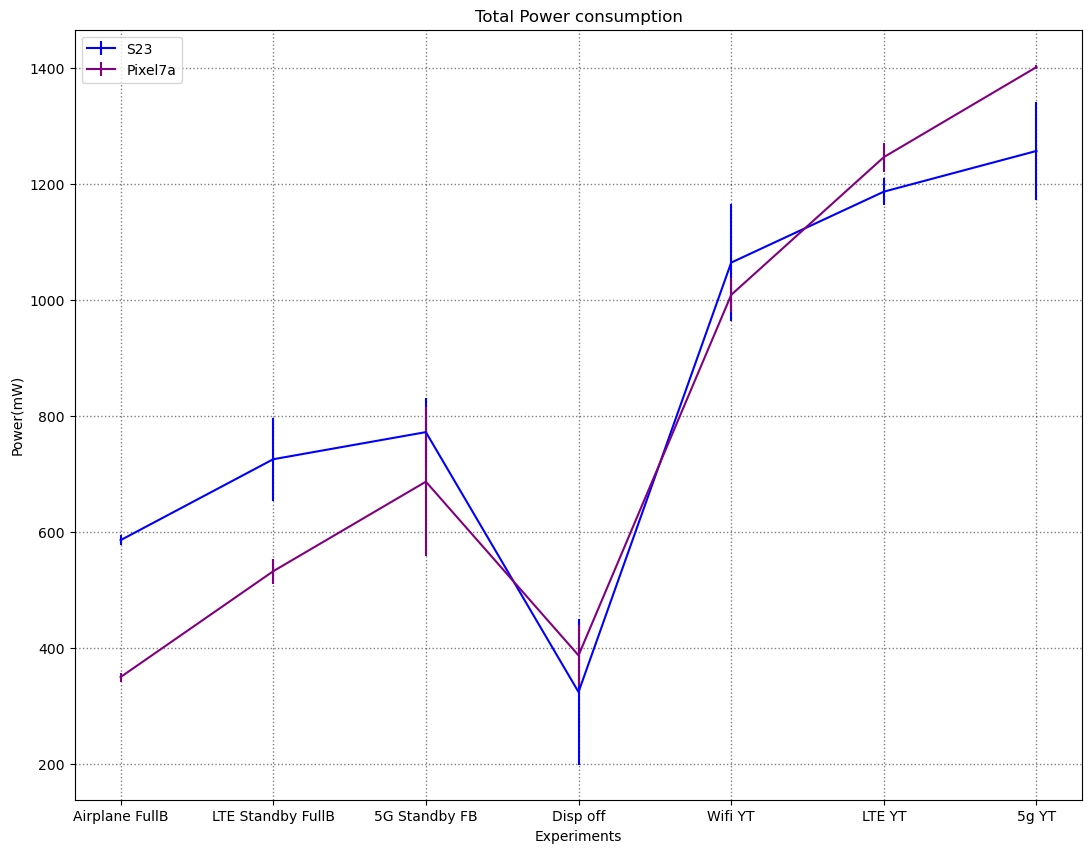

In [353]:
# col_list = ['Airplane','Standby','Airplane Full Brightness','Wifi_Youtube','5G_Youtube','Wifi_iperf1M_UL','5G_Iperf1M_UL']

legend_list = ['Airplane FullB','LTE Standby FullB','5G Standby FB','Disp off','Wifi YT','LTE YT','5g YT']
plt.rcParams['figure.figsize'] = [13, 10]
# for i in range(col_list):
plt.errorbar(range(len(legend_list)),battery_avg_s23,color='blue',yerr = error_s23,linestyle='-',label = 'S23')
plt.errorbar(range(len(legend_list)),battery_avg_pxl,color='purple',yerr = error_pxl,linestyle='-',label = 'Pixel7a')
plt.legend()
plt.title('Total Power consumption') 
plt.xlabel('Experiments')
plt.ylabel('Power(mW)')
plt.xticks(range(len(legend_list)),legend_list)
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
# plt.ylim([300,800])


Bar plots - standby (Fig 4)

In [324]:
pxl_odpm_pwrs = [np.mean(modem_pwr_pxl,0),np.mean(rfe_pwr_pxl,0),np.mean(display_pwr_pxl,0),np.mean(battery_pwr_data_pxl,0)]

In [354]:
combined_battery  = pd.DataFrame(np.mean(battery_pwr_data_pxl,0)).T
combined_battery.loc[-1] = pd.Series(np.mean(battery_pwr_data_s23,0))
combined_battery.set_axis(['Pixel','S23'])


,Airplane Full Brightness,LTE Standby FB,5G stdby FB,Stdby disp off,Wifi YT,LTE YT,5g YT
Pixel,349.696934,532.242338,686.665618,387.137842,1008.801547,1246.325261,1401.57232
S23,585.789562,725.365132,772.123312,323.931524,1064.474809,1186.780793,1257.004493


([<matplotlib.axis.XTick at 0x1edd249b790>,
 [Text(0, 0, 'Pixel'), Text(1, 0, 'S23')])

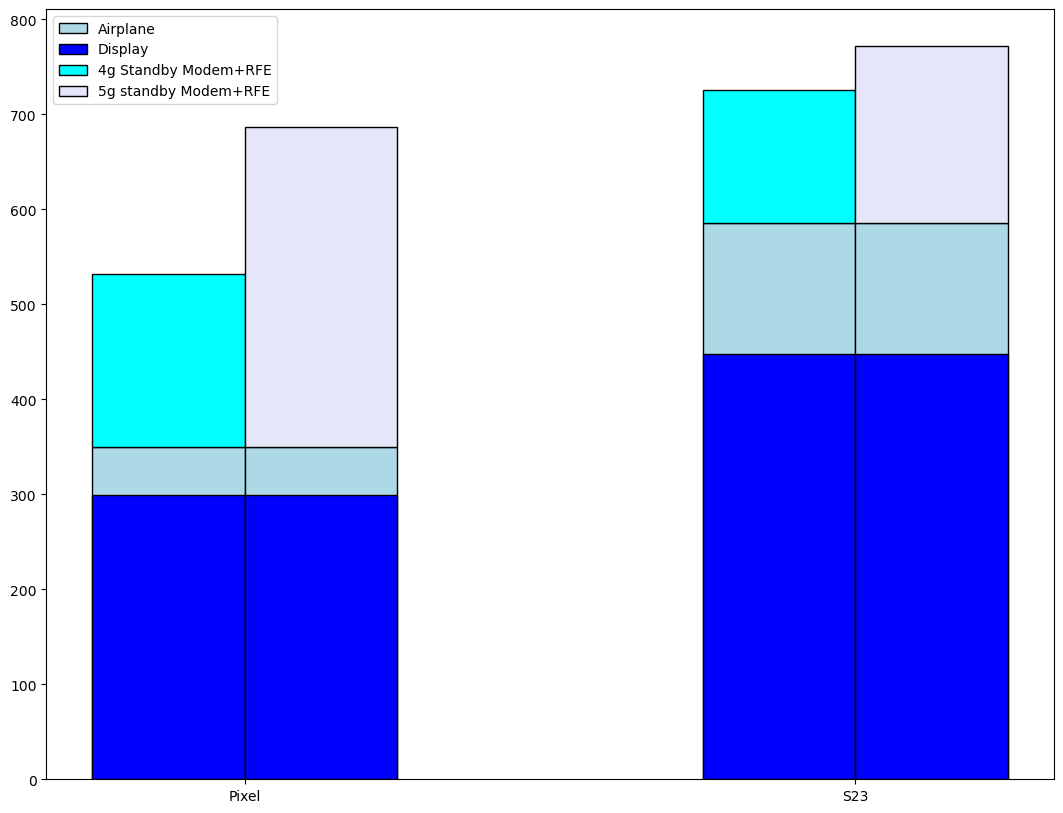

In [361]:
x = np.arange(2)
# ['Pixel 7a','S23]
airplane = combined_battery['Airplane Full Brightness']
lte_std = combined_battery['LTE Standby FB']-combined_battery['Airplane Full Brightness']
display = combined_battery['5G stdby FB']-combined_battery['Stdby disp off']
display_5g = combined_battery['5G stdby FB']-combined_battery['Stdby disp off']
std_5g= combined_battery['5G stdby FB']-combined_battery['Airplane Full Brightness']

width = 0.25
plt.bar(x-width/2,airplane,width,color='lightblue',edgecolor='k',label = 'Others') 
plt.bar(x-width/2,display,width,color='blue',edgecolor='k',label ='Display')
plt.bar(x-width/2,lte_std,width,bottom=airplane,color='cyan',label='4g Standby Modem+RFE',edgecolor='k')
# plt.bar(x,lte,width,bottom=airplane,color='cyan',label='Standby',edgecolor='k')

plt.bar(x+width/2,airplane,width,color='lightblue',edgecolor='k',)
plt.bar(x+width/2,display_5g,width,color='blue',edgecolor='k',)

plt.bar(x+width/2,std_5g,width,bottom=airplane,color='lavender',label='5g standby Modem+RFE',edgecolor='k')
plt.legend()
plt.xticks(x,['Pixel','S23'])

Fig 5 - youtube

([<matplotlib.axis.XTick at 0x1edd4eed250>,
 [Text(0, 0, 'Pixel'), Text(1, 0, 'S23')])

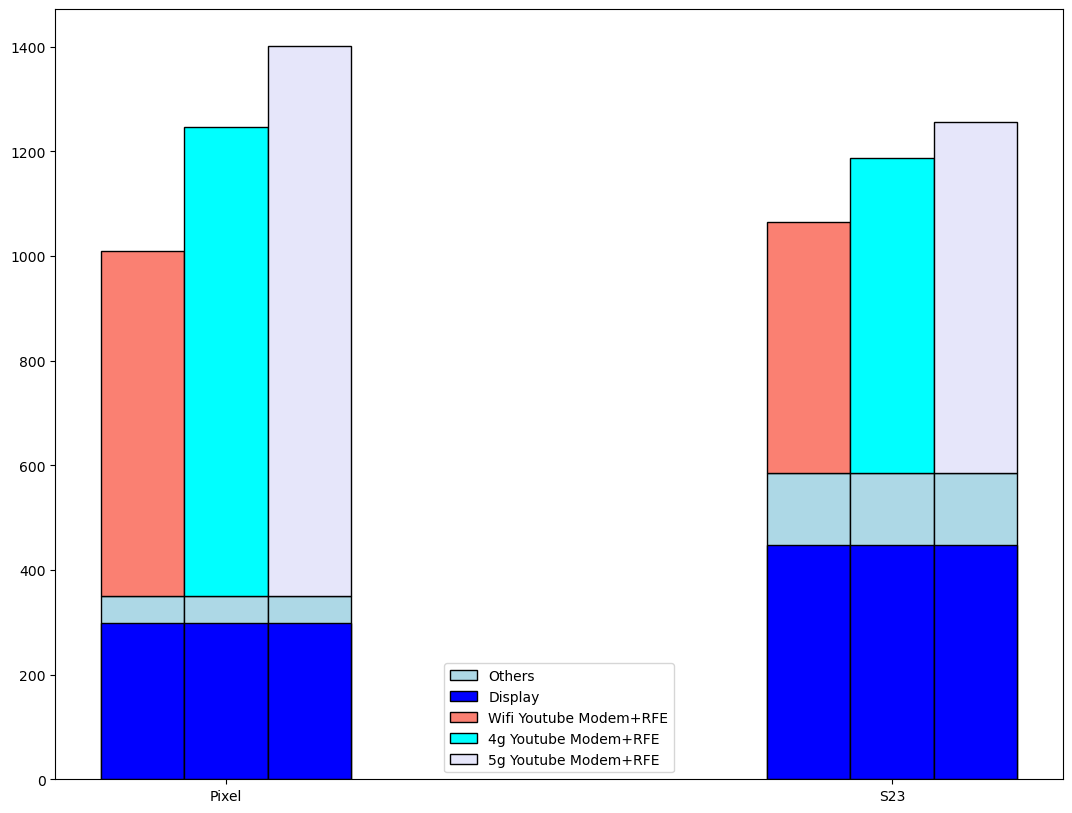

In [368]:
x = np.arange(2)
# ['Pixel 7a','S23]
airplane = combined_battery['Airplane Full Brightness']
display = combined_battery['5G stdby FB']-combined_battery['Stdby disp off']
wifi_yt = combined_battery['Wifi YT']-combined_battery['Airplane Full Brightness']
lte_yt = combined_battery['LTE YT']-combined_battery['Airplane Full Brightness']
yt_5g= combined_battery['5g YT']-combined_battery['Airplane Full Brightness']

width = 0.25/2
#wifi
plt.bar(x-width,airplane,width,color='lightblue',edgecolor='k',label = 'Others') 
plt.bar(x-width,display,width,color='blue',edgecolor='k',label ='Display')
plt.bar(x-width,wifi_yt,width,bottom=airplane,color='salmon',label='Wifi Youtube Modem+RFE',edgecolor='k')

#4g
plt.bar(x,airplane,width,color='lightblue',edgecolor='k') 
plt.bar(x,display,width,color='blue',edgecolor='k')
plt.bar(x,lte_yt,width,bottom=airplane,color='cyan',label='4g Youtube Modem+RFE',edgecolor='k')
# plt.bar(x,lte,width,bottom=airplane,color='cyan',label='Standby',edgecolor='k')

#5g
plt.bar(x+width,airplane,width,color='lightblue',edgecolor='k')
plt.bar(x+width,display,width,color='blue',edgecolor='k')
plt.bar(x+width,yt_5g,width,bottom=airplane,color='lavender',label='5g Youtube Modem+RFE',edgecolor='k')
plt.legend()
plt.xticks(x,['Pixel','S23'])

In [ ]:
num_traces = 2 #stdby nd youtube
ind =  np.arange(num_traces)   
width = 0.35 

pxl_legend = ['Modem','RFE','Display','Total ']

fig = plt.figure(figsize =(16,9))
# reduced_pow_mat[3,1] = 1.1*reduced_pow_mat[4,1]
pxl_list=[]
for i in range(7):
    if(i==0):
        pxl_list.append(plt.bar(ind, pxl_pwrs[:,i], width))
    else:
#         print(i)
#         print(reduced_pow_mat[:,0:i-1])
#         print(np.sum(reduced_pow_mat[:,0:i-1],1))
        p_list.append(plt.bar(ind, reduced_pow_mat[:,i], width, bottom = np.sum(reduced_pow_mat[:,0:i],1)))
plt.ylabel('Avg. Power Consumption compued over 30 sec (mW)',fontsize=16)

# plt.xticks(ind, ('Youtube', 'Video Call','Instagram','PokemonGo','Standby'),fontsize=16)
# plt.xticks(ind, ('Youtube', 'Video Call','Instagram','PokemonGo','Standby', 'iPerf 5Mbps'),fontsize=16)
# plt.xticks(ind, ('Youtube Trial 1, 5G', 'Youtube Trial 2, 5G', 'Youtube Trial 3 5G',
#                  'Youtube Trial 1, Wi-Fi', 'Youtube Trial 2, Wi-Fi', 'Youtube Trial 3 Wi-Fi',),fontsize=16)
# plt.xticks(ind, ('Video Call Trial 1, 5G', 'Video Call Trial 2, 5G', 'Video Call Trial 3 5G',
#                  'Video Call Trial 1, Wi-Fi', 'Video Call Trial 2, Wi-Fi', 'Video Call Trial 3 Wi-Fi',),fontsize=16)
# plt.xticks(ind, ('5G Far', '5G Medium', '5G Close', '4G Far', '4G Medium', '4G Close'),fontsize=16)
# plt.xticks(ind, ('Red Location (500m)', 'Orange Location (300m)', 'Green Location (100m)'),fontsize=16)
# plt.xticks(ind, ('4G Far', '4G Medium', '4G Close'),fontsize=16)
# plt.xticks(ind, ('Wifi 1Mbps', 'Cellular 1Mbps', 'Wifi 10Mbps','Cellular 10Mbps','Wifi Youtube 1080p','Cellular Youtube 1080p'),fontsize=16)
plt.xticks(ind, ('Wifi 1Mbps', 'Wifi 10Mbps','Wifi 100Mbps'),fontsize=16)
# plt.yticks(np.arange(0, 81, 10))
# cell_pow,cpu_pow,mem_pow,display_pow,LLDO_pow,sensor_pow,wifi_pow,other_pow
# print(reduced_pow_mat[:,3])
total_pow = np.sum(reduced_pow_mat,1)
# plt.legend(p_list, ('Cellular','CPU','Memory','Display','LDO','Sensor','WiFi','Others'))
# plt.legend(p_list, ('Cellular','Compute','Memory','Display','Others'),fontsize=14)
plt.legend(p_list, ('Cellular','Compute','Memory','Display','Camera', 'Wi-Fi','Others'),fontsize=14)
# plt.title('Ratio vs #femto BS')
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
plt.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=10)
print(total_pow[0]/total_pow[1])
plt.savefig("./barplot_energy.pdf")
plt.show()

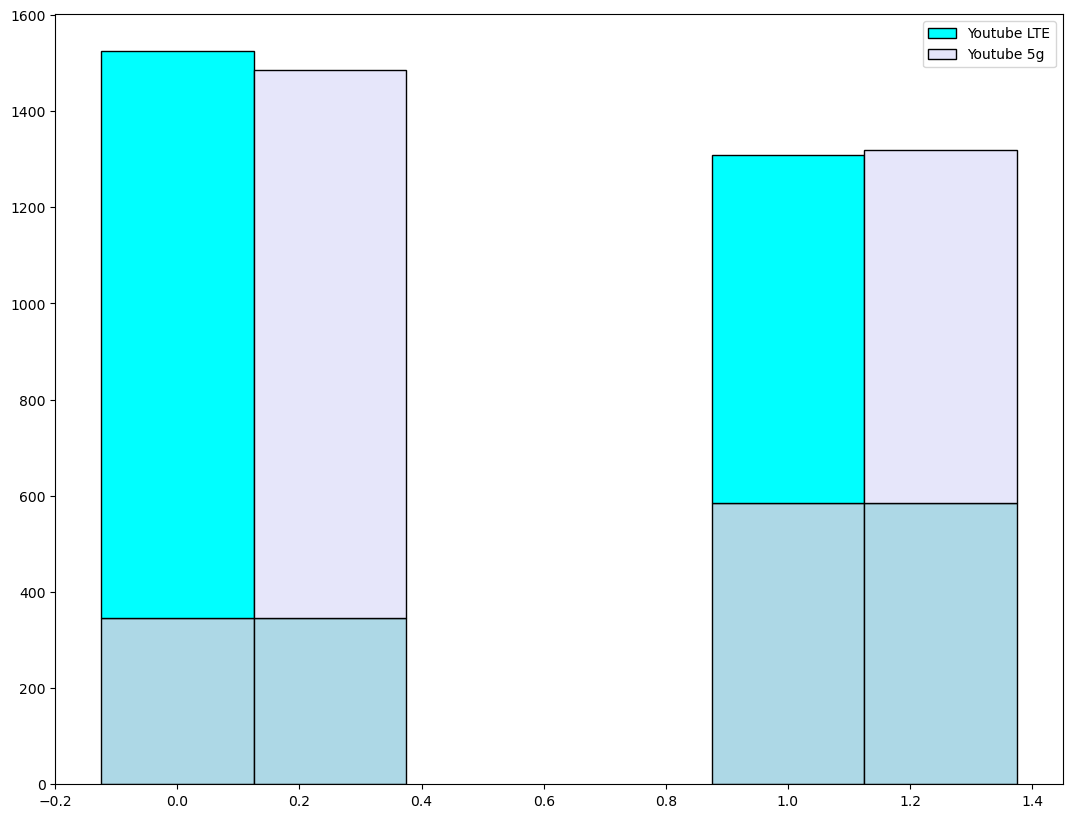

In [281]:
x = np.arange(2)
# ['Pixel 7a','S23]
airplane = combined_battery['Airplane Full Brightness']
lte = combined_battery['LTE YT']-combined_battery['Airplane Full Brightness']
fg= combined_battery['5g YT']-combined_battery['Airplane Full Brightness']

width = 0.25
plt.bar(x,airplane,width,color='lightblue',edgecolor='k')
plt.bar(x,lte,width,bottom=airplane,color='cyan',label='Youtube LTE',edgecolor='k')
# plt.bar(x,lte,width,bottom=airplane,color='cyan',label='Standby',edgecolor='k')

plt.bar(x+width,airplane,width,color='lightblue',edgecolor='k')
plt.bar(x+width,fg,width,bottom=airplane,color='lavender',label='Youtube 5g',edgecolor='k')
plt.legend()


In [185]:
battery_pwr_data_s23

,Airplane,Airplane Full Brightness,Standby,Wifi_Youtube,5G_Youtube,Wifi_iperf1M_UL,5G_Iperf1M_UL
0,582.213152,713.62881,1163.028184,1201.789353,1330.643333,2184.931106,4343.151148
1,597.291232,790.224217,1181.180585,1029.496033,1139.26785,2157.517119,3440.675574
2,577.864301,836.13048,1158.262213,962.13904,1301.102296,2092.153027,4054.195825


In [192]:
battery_diff_s23 = pd.DataFrame()
#                             ,'Youtube','Wifi_iperf1M','Wifi_youtube'])
battery_diff_s23['Standby'] = battery_pwr_data_pxl.Standby-battery_pwr_data_pxl.Airplane
battery_diff_s23['5G_Iperf1M_UL'] = battery_pwr_data_pxl['5G_Iperf1M_UL']-battery_pwr_data_pxl.Airplane
battery_diff_s23['5G_Youtube'] = battery_pwr_data_pxl['5G_Youtube']-battery_pwr_data_pxl.Airplane
battery_diff_s23['Wifi_iperf1M_UL'] = battery_pwr_data_pxl['Wifi_iperf1M_UL']-battery_pwr_data_pxl.Airplane
battery_diff_s23['Wifi_Youtube'] = battery_pwr_data_pxl['Wifi_Youtube']-battery_pwr_data_pxl.Airplane
battery_diff_s23

,Standby,5G_Iperf1M_UL,5G_Youtube,Wifi_iperf1M_UL,Wifi_Youtube
0,580.815031,3760.937996,748.430181,1602.717954,619.5762
1,583.889353,2843.384342,541.976618,1560.225887,432.204802
2,580.397912,3476.331524,723.237996,1514.288727,384.274739


In [ ]:
battery_diff_pxl = pd.DataFrame()
#                             ,'Youtube','Wifi_iperf1M','Wifi_youtube'])
battery_diff_pxl['Standby'] = battery_pwr_data_s23.Standby-battery_pwr_data_s23.Airplane
battery_diff_pxl['5G_Iperf1M_UL'] = battery_pwr_data_s23['5G_Iperf1M_UL']-battery_pwr_data_s23.Airplane
battery_diff_pxl['5G_Youtube'] = battery_pwr_data_s23['5G_Youtube']-battery_pwr_data_s23.Airplane
battery_diff_pxl['Wifi_iperf1M_UL'] = battery_pwr_data_s23['Wifi_iperf1M_UL']-battery_pwr_data_s23.Airplane
battery_diff_pxl['Wifi_Youtube'] = battery_pwr_data_s23['Wifi_Youtube']-battery_pwr_data_s23.Airplane
battery_diff_pxl

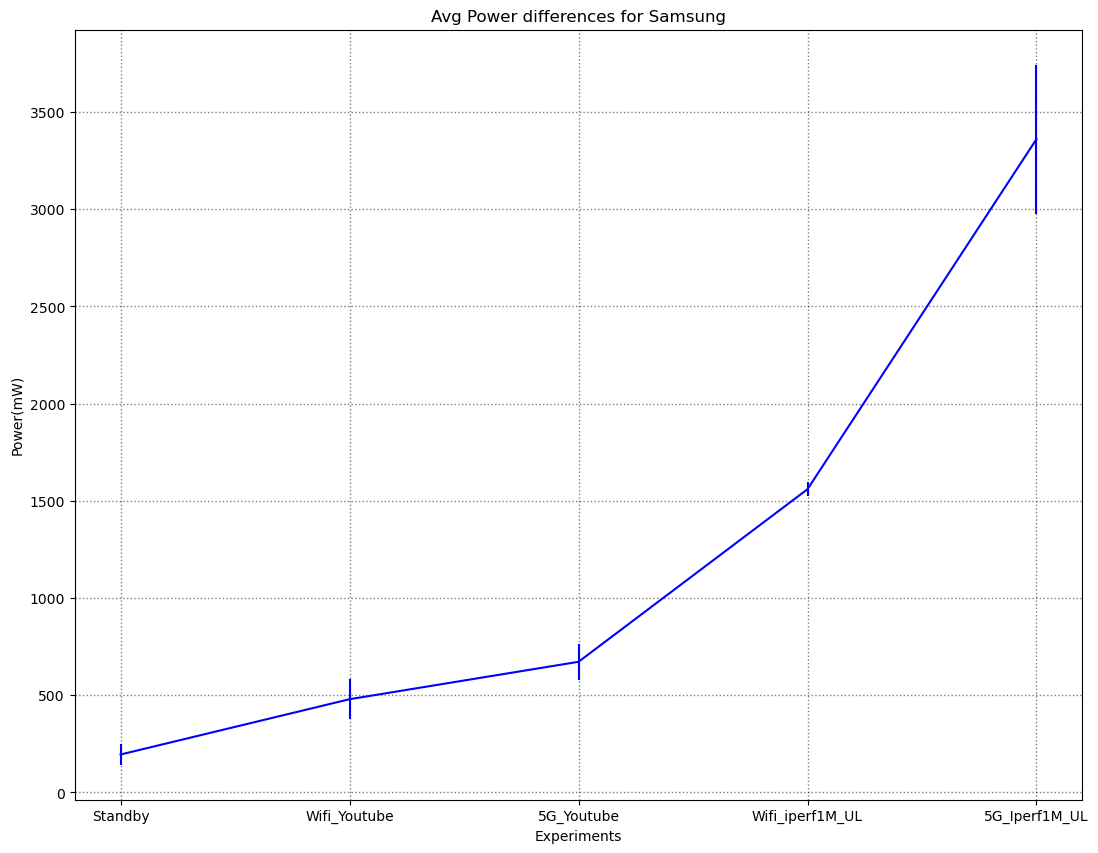

In [166]:
battery_diff_avg = np.array(np.mean(battery_diff_s23,0))
plt.rcParams['figure.figsize'] = [13, 10]
plt.errorbar(range(num_tps-2),battery_diff_avg,color='blue',yerr = np.array(np.std(battery_diff,0)),linestyle='-',label = 'Power from Battery counters')
plt.title('Avg Power differences for Samsung') 
plt.xlabel('Experiments')
plt.ylabel('Power(mW)')
plt.xticks(range(num_tps-2),col_list[2:])
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
# plt.ylim([300,800])

In [168]:
battery_ratios = battery_diff.reset_index(drop=True)/battery_current_all.iloc[:,2:].reset_index(drop=True)
battery_ratios

,Standby,Wifi_Youtube,5G_Youtube,Wifi_iperf1M_UL,5G_Iperf1M_UL
0,0.184151,0.515545,0.562457,0.733532,0.865947
1,0.24415,0.419822,0.475724,0.723158,0.826403
2,0.308883,0.399396,0.555866,0.723794,0.857465


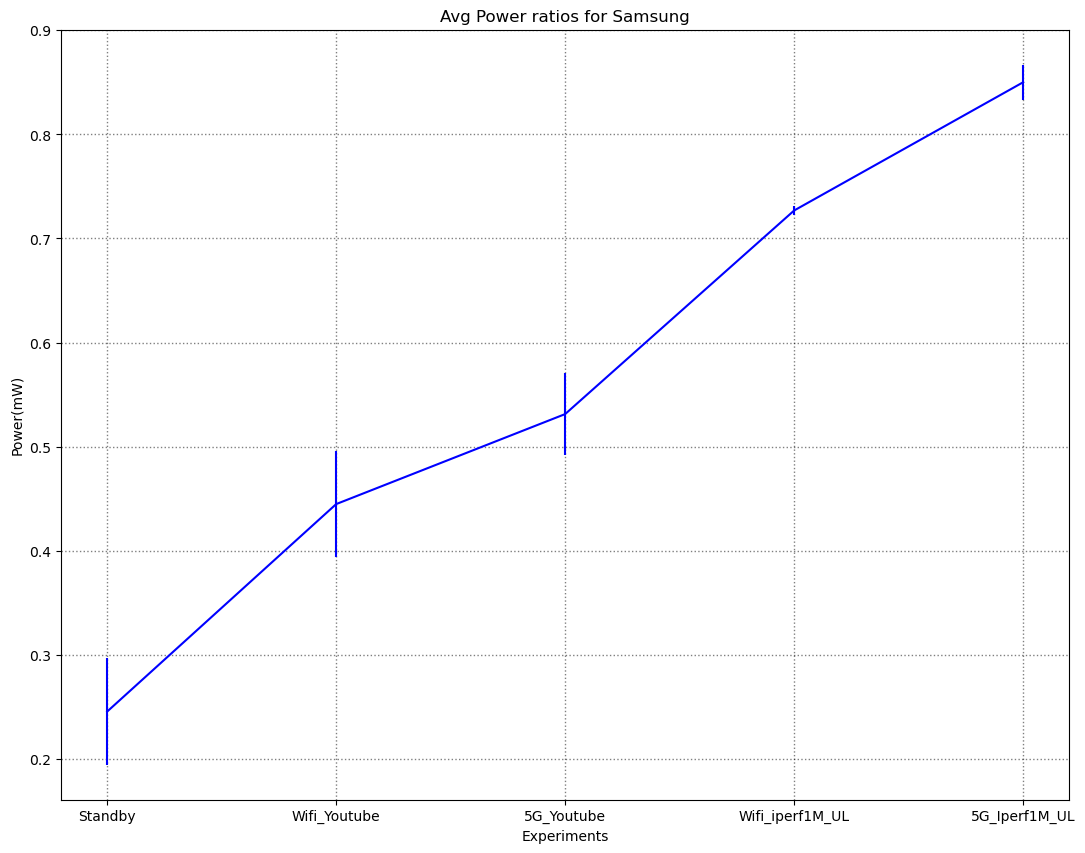

In [171]:
battery_ratio_avg = np.array(np.mean(battery_ratios,0))
plt.rcParams['figure.figsize'] = [13, 10]
plt.errorbar(range(num_tps-2),battery_ratio_avg,color='blue',yerr = np.array(np.std(battery_ratios,0)),linestyle='-',label = 'Power from Battery counters')
plt.title('Avg Power ratios for Samsung') 
plt.xlabel('Experiments')
plt.ylabel('Power(mW)')
plt.xticks(range(num_tps-2),col_list[2:])
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
# plt.ylim([300,800])

In [84]:
airplane = [np.mean(battery[0][2][0]),np.mean(battery[1][2][0]),np.mean(battery[2][2][0])]
display(airplane)

[582.213152400835, 597.2912317327766, 577.8643006263048]

In [85]:
ratios = [battery[0][0]/np.mean(battery[0][2][1]),battery[1][0]/np.mean(battery[1][2][1]),battery[2][0]/np.mean(battery[2][2][1])]

In [86]:
standby = [np.mean(battery[0][2][1]),np.mean(battery[1][2][1]),np.mean(battery[2][2][1])]
display(standby)

[1163.028183716075, 1181.1805845511483, 1158.2622129436327]

In [149]:
legend_list = ['Standby','Iperf1M','Iperf5M','Iperf10M','Iperf50M']
plt.rcParams['figure.figsize'] = [13, 10]
battery_avg = [0,0]
for i in range(num_exps):
    battery_avg[0] = battery_avg[0] + battery[i][0][1]
#     battery_avg[1] = battery_avg[1] + battery[i][1][1]
# battery_avg = battery_avg/num_exps

plt.plot([0,120],[battery_avg,battery_avg])
# plt.plot(np.mean(pct_battery,0)[0:-1],color='blue',linestyle='-',marker='o',label = '% in Battery power')
# plt.errorbar(range(5),battery_avg,yerr=np.std(battery,1),color='blue')
# plt.plot(np.mean(pct_cell,0)[0:-1],color='purple',linestyle='-',marker='>',label='% in Total ODPM')
# plt.errorbar(range(5),odpm_total_avg,yerr=np.std(odpm_total,1),color='purple')

# plt.errorbar(range(5),battery_avg,yerr=np.std(battery,1),color='blue')
# plt.plot(modem_avg,color='green',linestyle='-',marker='x',label='Modem Power')
# plt.legend()
# plt.title('% Modem + RFE in Total ODPM and Total Battery consumption') 
# plt.xlabel('Experiment')
# plt.ylabel('Ratio')
# plt.xticks(range(0,4),legend_list[0:-1])
# plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
# plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
# plt.ylim([0,1])

IndexError: invalid index to scalar variable.

In [150]:
battery_avg = np.mean(battery[0:-1],1)
odpm_total_avg = np.mean(odpm_total[0:-1],1)
error = odpm_total_avg-battery_avg
# modem_avg = np.mean(modem,1)
legend_list = ['Standby','Iperf1M','Iperf5M','Iperf10M','Iperf50M']
plt.rcParams['figure.figsize'] = [13, 10]
plt.plot(battery_avg,color='blue',linestyle='-',marker='o',label = 'Power from Battery counters')
plt.errorbar(range(4),battery_avg,yerr=np.std(battery[0:-1],1),color='blue')
plt.plot(odpm_total_avg,color='purple',linestyle='-',marker='>',label='Modem + RFE power (ODPM)')
plt.errorbar(range(4),odpm_total_avg,yerr=np.std(odpm_total[0:-1],1),color='purple')

# plt.errorbar(range(5),battery_avg,yerr=np.std(battery,1),color='blue')
# plt.plot(modem_avg,color='green',linestyle='-',marker='x',label='Modem Power')
plt.legend()
plt.title('Avg powers over 10 experiments') 
plt.xticks(range(0,4),legend_list[0:-1])
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
plt.ylim([300,800])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3) + inhomogeneous part.

In [ ]:
battery_error = [[],[],[],[]]
total_error = [[],[],[],[]]

legend_list = ['Standby','Iperf1M','Iperf5M','Iperf10M']
plt.rcParams['figure.figsize'] = [13, 10]
for i in range(4):
    battery_error[i] = [abs(b-m) for b,m in zip(battery[i],modem[i])]
    total_error[i] = [abs(b-m) for b,m in zip(total[i],modem[i])]
    plt.subplot(2,2,i+1)
    plt.plot(battery[i],label='battery',color = 'blue')
    plt.plot(total[i],label='total',color='purple')
    plt.plot(modem[i],label='modem',color='green')
    plt.legend()
    plt.xlabel('Experiment number')
    plt.ylabel('Power (mW)')
    plt.title(legend_list[i])
    plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
    plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)

In [ ]:
plt.rcParams['figure.figsize'] = [13, 10]
plt.boxplot(battery_error)
plt.title('Box plot for absolute error') 
plt.xticks(range(1,5),legend_list)
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)

In [ ]:
tp_list.append(TraceProcessor(trace='../Perfetto_traces/5_3_no_charge_airplane1.perfetto-trace')) #10-15 dBm
tp_list.append(TraceProcessor(trace='../Perfetto_traces/5_3_no_charge_stdby1.perfetto-trace')) #10-15 dBm
tp_list.append(TraceProcessor(trace='../Perfetto_traces/5_3_no_charge_iperf0.perfetto-trace')) #10-15 dBm
num_tps = len(tp_list)
id_mapper = [27]+list(range(1,25))
# string_mapper = ["Battery charge","Battery capacity pct","Battery current","Battery avg current","Modem","RFE","mmWave","Display"]

df_list_cleaned = [[tp.query('SELECT ts,value FROM counter WHERE track_id='+str(i)+'')
               .as_pandas_dataframe().replace(np.nan,0)
               .values.tolist() for i in id_mapper] for tp in tp_list]
[b1,b2,m1,m2,t1,t2] = get_powers(num_tps,df_list_cleaned)


Plotting all powers for different modes

Plotting difference in powers across different modes

In [151]:
delta_battery1= (np.mean(battery_power[1])-np.mean(battery_power[0]))
delta_total1= (np.mean(total_power[1])-np.mean(total_power[0]))*4/1000
delta_modem1 = (np.mean(modem_power[1])-np.mean(modem_power[0]))*4/1000
delta_rfe1 = (np.mean(rfe_power[1])-np.mean(rfe_power[0]))*4/1000

delta_battery2= (np.mean(battery_power[2])-np.mean(battery_power[0]))
delta_total2= (np.mean(total_power[2])-np.mean(total_power[0]))*4/1000
delta_modem2 = (np.mean(modem_power[2])-np.mean(modem_power[0]))*4/1000
delta_rfe2 = (np.mean(rfe_power[2])-np.mean(rfe_power[0]))*4/1000

NameError: name 'battery_power' is not defined

NameError: name 'delta_battery1' is not defined

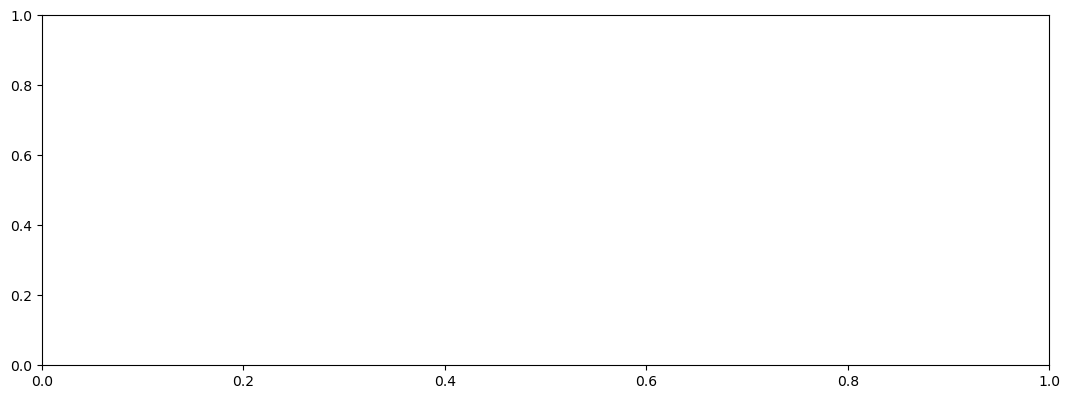

In [152]:
'''Plots'''
plt.rcParams['figure.figsize'] = [13, 10]
plt.subplot(2,1,1)
# plt.plot(x_vals,delta_total1,label='Total power(OPDM)',color='blue')
avg = np.mean(delta_battery1)
plt.plot([x_vals[0],x_vals[-1]],[avg,avg],linestyle='--',label='Avg Battery power : '+str(avg),color='blue')

avg = np.mean(delta_total1)
plt.plot([x_vals[0],x_vals[-1]],[delta_total1,delta_total1],linestyle='--',label='Avg Total power : '+str(avg),color='purple')
avg = np.mean(delta_modem1)
# plt.plot(x_vals,delta_modem1,label='Modem power',color='green')
plt.plot([x_vals[0],x_vals[-1]],[delta_modem1,delta_modem1],linestyle='--',label='Avg modem power : '+str(avg),color='green')

plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Power (mW)", fontsize=16)
plt.title("Total power vs Modem power difference between standby and airplane")
plt.legend(fontsize=10)
# plt.title('Ratio vs #femto BS')
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
# plt.minorticks_on()

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.subplot(2,1,2)
# plt.plot(x_vals,delta_total2,label='Total power(OPDM)',color='blue')
avg = np.mean(delta_battery2)
plt.plot([x_vals[0],x_vals[-1]],[avg,avg],linestyle='--',label='Avg Battery power : '+str(avg),color='blue')
avg = np.mean(delta_total2)
plt.plot([x_vals[0],x_vals[-1]],[delta_total2,delta_total2],linestyle='--',label='Avg Total power : '+str(avg),color='purple')
avg = np.mean(delta_modem2)
# plt.plot(x_vals,delta_modem2,label='Modem power',color='green')
plt.plot([x_vals[0],x_vals[-1]],[delta_modem2,delta_modem2],linestyle='--',label='Avg Modem power : '+str(avg),color='green')
avg = np.mean(delta_rfe2)
# plt.plot([x_vals[0],x_vals[-1]],[delta_rfe2,delta_rfe2],linestyle='--',label='Avg rfe power : '+str(avg),color='teal')

plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Power (mW)", fontsize=16)
plt.title("Total power vs Modem power difference between iperf and airplane")
plt.legend(fontsize=10)
# plt.title('Ratio vs #femto BS')
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
# plt.minorticks_on()

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
# plt.ylim([0,2150])
# print(total_power)

Add all powers for different modes into a data frame and view

In [ ]:
tp = TraceProcessor(trace='../Perfetto_traces/5_2_battery_trial.perfetto-trace') #10-15 dBm

# print(tp)
# select ts, t.name, value from counter as c left join counter_track t on c.track_id = t.i
qr_it = tp.query('SELECT ts,t.name,value,track_id FROM counter as c LEFT JOIN counter_track t ON c.track_id=t.id')
# print(qr_it)
qr_it_pandas = qr_it.as_pandas_dataframe()
names = qr_it_pandas[16:40].name
all_powers.columns = ['Airplane','Standby','Iperf']
all_powers_diff=all_powers.assign(Airplane_to_stdby = all_powers.Standby -all_powers.Airplane)
all_powers_diff = all_powers_diff.assign(Airplane_to_iperf = all_powers.Iperf -all_powers.Airplane)
all_powers_diff.set_index(names,inplace=True)
display(all_powers_diff)

In [153]:
delta_battery1= ((battery_power[1])-(battery_power[0]))
delta_total1= ((total_power[1])-(total_power[0]))*4/1000
delta_modem1 = ((modem_power[1])-(modem_power[0]))*4/1000
delta_rfe1 = ((rfe_power[1])-(rfe_power[0]))*4/1000

delta_battery2= ((battery_power[2])-(battery_power[0]))
delta_total2= ((total_power[2])-(total_power[0]))*4/1000
delta_modem2 = ((modem_power[2])-(modem_power[0]))*4/1000
delta_rfe2 = ((rfe_power[2])-(rfe_power[0]))*4/1000
plt.rcParams['figure.figsize'] = [13, 10]
plt.subplot(2,1,1)
plt.plot(x_vals[0:len(battery_power[1,:])],delta_battery1,label='Total power(OPDM)',color='blue')
avg = np.mean(delta_battery1)
plt.plot([x_vals[0],x_vals[-1]],[avg,avg],linestyle='--',label='Avg Battery power : '+str(avg),color='blue')

plt.plot(x_vals[0:len(total_power[1,:])],delta_total1,label='Total power(OPDM)',color='purple')
avg = np.mean(delta_total1)
plt.plot([x_vals[0],x_vals[-1]],[avg,avg],linestyle='--',label='Avg Total power : '+str(avg),color='purple')
avg = np.mean(delta_modem1+delta_rfe1)
plt.plot(x_vals,delta_modem1+delta_rfe1,label='Modem power',color='green')
plt.plot([x_vals[0],x_vals[-1]],[avg,avg],linestyle='--',label='Avg modem + RFE power : '+str(avg),color='green')

plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Power (mW)", fontsize=16)
plt.title("Total power vs Modem power difference between standby and airplane")
plt.legend(fontsize=10)
# plt.title('Ratio vs #femto BS')
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
# plt.minorticks_on()

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)

plt.subplot(2,1,2)
plt.plot(x_vals[0:len(battery_power[1,:])],delta_battery2,label='Total power(OPDM)',color='blue')
avg = np.mean(delta_battery2)
plt.plot([x_vals[0],x_vals[-1]],[avg,avg],linestyle='--',label='Avg Battery power : '+str(avg),color='blue')
plt.plot(x_vals[0:len(total_power[1,:])],delta_total2,label='Total power(OPDM)',color='purple')
avg = np.mean(delta_total2)
plt.plot([x_vals[0],x_vals[-1]],[avg,avg],linestyle='--',label='Avg Total power : '+str(avg),color='purple')
avg = np.mean(delta_modem2+delta_rfe2)
plt.plot(x_vals,delta_modem2+delta_rfe2,label='Modem power',color='green')
plt.plot([x_vals[0],x_vals[-1]],[avg,avg],linestyle='--',label='Avg Modem +RFE power : '+str(avg),color='green')
avg = np.mean(delta_rfe2)
# plt.plot([x_vals[0],x_vals[-1]],[delta_rfe2,delta_rfe2],linestyle='--',label='Avg rfe power : '+str(avg),color='teal')

plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Power (mW)", fontsize=16)
plt.title("Total power vs Modem power difference between iperf and airplane")
plt.legend(fontsize=10)
# plt.title('Ratio vs #femto BS')
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
# plt.minorticks_on()

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
# plt.ylim([0,2150])
# print(total_power)

NameError: name 'battery_power' is not defined

In [ ]:
df_np = np.array(df_list_cleaned)
curr_mode0 = df_np[0,2,:,1]
curr_mode1 = df_np[1,2,:,1]
curr_mode2 = df_np[2,2,:,1]

mdm_pwr0 = (df_np[0,4,1:,1] - df_np[0,4,0:-1,1])*4/1000
mdm_pwr1 = (df_np[1,4,1:,1] - df_np[1,4,0:-1,1])*4/1000
mdm_pwr2 = (df_np[2,4,1:,1] - df_np[2,4,0:-1,1])*4/1000
mdm_pwr_diff1 = (mdm_pwr1-mdm_pwr0)
mdm_pwr_diff2 = (mdm_pwr2-mdm_pwr1)

battery_power1 =3.7*(curr_mode1-curr_mode0)*10**(-3)
battery_power2 = 3.7*(curr_mode2-curr_mode1)*10**(-3)
x_vals = df_np[0,2,:,0];
plt.rcParams['figure.figsize'] = [13, 10]

plt.subplot(1,2,1)
# *4 because power measurements done roughly over 250ms (1/4 seconds) interval
plt.plot(x_vals,battery_power1, color = 'blue',
         label="Battery power diff stdby-airp")
min_time = np.min(x_vals[initial_offset:])
max_time = np.max(x_vals[initial_offset:])
plt.plot([min_time,max_time],[np.mean(battery_power1),np.mean(battery_power1)],color='blue', linestyle="--", label = "Avg Pow: "+str(np.mean(battery_power1))+ " mW")
plt.plot(x_vals,battery_power2,color='teal',label="Battery power diff iperf-stdby")
plt.plot([min_time,max_time],[np.mean(battery_power2),np.mean(battery_power2)],color='teal', linestyle="--", label = "Avg Pow: "+str(np.mean(battery_power2))+ " mW")
plt.plot(x_vals[1:],mdm_pwr_diff1,color= 'salmon',label="Modem power diff stdby-airp")
plt.plot([min_time,max_time],[np.mean(mdm_pwr_diff1),np.mean(mdm_pwr_diff1)],color='salmon', linestyle="--", label = "Avg Pow: "+str(np.mean(mdm_pwr_diff1))+ " mW")
plt.plot(x_vals[1:],mdm_pwr_diff2,color='orange',label="Modem power diff iperf-stdby")
plt.plot([min_time,max_time],[np.mean(mdm_pwr_diff2),np.mean(mdm_pwr_diff2)], color='orange',linestyle="--", label = "Avg Pow: "+str(np.mean(mdm_pwr_diff2))+ " mW")

plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Power (mW)", fontsize=16)
plt.title('Modem')
plt.legend(fontsize=10)
# plt.title('Ratio vs #femto BS')
plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
# plt.minorticks_on()

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.ylim([0,2150])
# print(np.mean(curr_mode1**2-curr_mode0**2)*10**(-6),mdm_pwr_diff1)
# print(np.mean(curr_mode2**2-curr_mode1**2)*10**(-6),mdm_pwr_diff2)

In [154]:
df_np = np.array(df_list_cleaned[tp_idx])
df_np[:,:,0] = df_np[:,:,0] - np.tile(df_np[:,0,0],[df_np.shape[1],1]).T
#     df_np[:,:,:,0] = df_np[:,:,:,0] - np.tile(df_np[:,:,0,0],[df_np.shape[2],1,1]).transpose(1,2,0) 
df_np[:,:,0] = df_np[:,:,0]/1e9

i =3
x_vals = df_np[i-1,:,0]
y_vals = df_np[i-1,:,1]
delta_y_vals = np.copy(y_vals)
delta_y_vals[1:] = delta_y_vals[1:]-delta_y_vals[0:y_vals.size-1]
delta_y_vals[0] = 0
print(y_vals)
# avg_pow_indiv = np.mean(delta_y_vals[initial_offset:])
# print("Average for "+str(string_mapper[i-1])+": "+str(avg_pow_indiv))
# #         plt.subplot(2,2,i)
# fig1.add_trace(go.Scatter(x=x_vals[initial_offset:],y=delay_y_vals[initial_offset:],
#                       line_color= color_list[tp_idx],name=legend_list[tp_idx],
#                     legendgroup=tp_idx,showlegend=(i==1)),row=int((i+1)/2),col=(i-1)%2+1)
# fig1.add_trace(go.Scatter(x=[min_time,max_time],y=[avg_pow_indiv,avg_pow_indiv],
#                      mode='lines', line={'dash': 'dash', 'color': color_list[tp_idx]},name="Avg of "+str(string_mapper[i-1])+": "+str(avg_pow_indiv.round(2)) ,
#                      legendgroup=tp_idx),row=int((i+1)/2),col=(i-1)%2+1)

# min_time = np.min(x_vals[initial_offset:])
# max_time = np.max(x_vals[initial_offset:])

NameError: name 'tp_idx' is not defined

In [155]:
## plotly plots
color_list = ['blue','green','teal','pink','salmon','blue','green','teal','pink','salmon']
# legend_list = ["Random schedule for 60s", "MIMO ","Standby"]
legend_list = ["Airplane","Standby","Iperf"]
legend_list2 = ["Charge","Capacity(%)","Current","Avg current","Modem","RFE","mmWave","Display"]
# legend_list = ["Brightness - 35%","Brightness - 70%","Brightness - 100%","Reading3","Standby_to_airplane","Standby"]
# legend_list = ["Standby to Wifi","Wifi Alone","Airplane alone","Standby"]

# string_mapper_AS = ["Cellular (Total)","Display"]
initial_offset = 2
# end_offset = 72
fig1 = make_subplots(rows=2,cols=2,subplot_titles=("Charge","Capacity(%)","Current","Avg current"),column_widths=[1,1],row_heights=[1,1])
fig2 = make_subplots(rows=2,cols=2,subplot_titles=("Modem","RFE","mmWave","Display"),column_widths=[1,1],row_heights=[1,1])

for tp_idx in range(num_tps):
    df_np = np.array(df_list_cleaned[tp_idx])
    df_np[:,:,0] = df_np[:,:,0] - np.tile(df_np[:,0,0],[df_np.shape[1],1]).T
#     df_np[:,:,:,0] = df_np[:,:,:,0] - np.tile(df_np[:,:,0,0],[df_np.shape[2],1,1]).transpose(1,2,0) 
    df_np[:,:,0] = df_np[:,:,0]/1e9
    
    for i in range(1,5):
        x_vals = df_np[i-1,:,0]
        y_vals = df_np[i-1,:,1]
#         x_vals = x_vals[:min(x_vals.size,end_offset)]
#         y_vals = y_vals[:min(y_vals.size,end_offset)]
        delta_y_vals = np.copy(y_vals)
        delta_y_vals[1:] = delta_y_vals[1:]-delta_y_vals[0:y_vals.size-1]
        delta_y_vals[0] = 0
        avg_pow_indiv = np.mean(3.7*10**(-3)*(abs(y_vals[initial_offset:])))
        print("Average Power "+str(string_mapper[i-1])+": "+str(avg_pow_indiv)+" mW")
#         plt.subplot(2,2,i)
        fig1.add_trace(go.Scatter(x=x_vals[initial_offset:],y=3.7*10**(-3)*(abs(y_vals[initial_offset:])),
                              line_color= color_list[tp_idx],name=legend_list[tp_idx],
                            legendgroup=tp_idx,showlegend=(i==1)),row=int((i+1)/2),col=(i-1)%2+1)
    
        min_time = np.min(x_vals[initial_offset:])
        max_time = np.max(x_vals[initial_offset:])
        fig1.add_trace(go.Scatter(x=[min_time,max_time],y=[avg_pow_indiv,avg_pow_indiv],
                             mode='lines', line={'dash': 'dash', 'color': color_list[tp_idx]},name="Avg of "+str(string_mapper[i-1])+": "+str(avg_pow_indiv.round(2)) ,
                             legendgroup=tp_idx),row=int((i+1)/2),col=(i-1)%2+1)

        
    for i in range(5,9):
        x_vals = df_np[i-1,:,0]
        y_vals = df_np[i-1,:,1]

#         x_vals = x_vals[:min(x_vals.size,end_offset)]
#         y_vals = y_vals[:min(y_vals.size,end_offset)]
        delta_y_vals = np.copy(y_vals)
        delta_y_vals[1:] = delta_y_vals[1:]-delta_y_vals[0:y_vals.size-1]
        delta_y_vals[0] = 0
        avg_pow_indiv = np.mean(delta_y_vals[initial_offset:]*(4/1000))
        print("Average Power (mW) for "+str(string_mapper[i-1])+": "+str(avg_pow_indiv)+" mW")
#         plt.subplot(2,2,i) 
        fig1.add_trace(go.Scatter(x=x_vals[initial_offset:],y=delta_y_vals[initial_offset:]*(4/1000),
                              line_color= color_list[i],name=legend_list[tp_idx]+" - " + legend_list2[i-1],
                            legendgroup=tp_idx,showlegend=True),row=int(2),col=(1))
        fig1.add_trace(go.Scatter(x=[min_time,max_time],y=[avg_pow_indiv,avg_pow_indiv],
             mode='lines', line={'dash': 'dash', 'color': color_list[i]},name="Avg Pow of "+str(string_mapper[i-1])+": "+str(avg_pow_indiv.round(2))+ " mW",
             legendgroup=tp_idx),row=int(2),col=(2))
        # *4 because power measurements done roughly over 250ms (1/4 seconds) interval
#         plt.plot(x_vals[initial_offset:],delta_y_vals[initial_offset:]*(4/1000), 
#                  color=color_list[tp_idx],linewidth=2, linestyle=line_list[tp_idx], label=legend_list[tp_idx])
        min_time = np.min(x_vals[initial_offset:])
        max_time = np.max(x_vals[initial_offset:])
#         fig.add_trace(go.Scatter(x=[min_time,max_time],y=[avg_pow_indiv,avg_pow_indiv],
#                                  mode='lines', line={'dash': 'dash', 'color': color_list[tp_idx]},name="Avg Pow of "+str(string_mapper[i-1])+": "+str(avg_pow_indiv.round(2))+ " mW",
#                                  legendgroup=tp_idx),row=int((i+1)/2),col=(i-1)%2+1)
#         fig.add_annotation(xref="x domain", yref="y domain",
#                   x=1, y=1,text="Avg Pow: "+str(avg_pow_indiv.round(2))+ " mW",showarrow=True)
#         plt.xlabel("Time (seconds)", fontsize=12)
#         plt.ylabel("Power (mW)", fontsize=16)
#         plt.legend(fontsize=10)
        # plt.title('Ratio vs #femto BS')
#         plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
#         plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
#         plt.minorticks_on()
        
#         plt.xticks(fontsize=12)
#         plt.yticks(fontsize=14)
fig1.update_xaxes(title='Time')
fig1.update_yaxes(range=[-10,6050],title='Power')
fig1.update_layout(height=800, width=1.3*800, 
                  title=dict(text="Power consumption of UE with iperf&sleep", font=dict(size=15)),
                  showlegend=enable_legend)

fig1.show()
fig2.update_xaxes(title='Time')
fig2.update_yaxes(range=[0,2150],title='Power')
fig2.update_layout(height=800, width=1.3*800, 
                  title=dict(text="Power consumption of UE with iperf&sleep", font=dict(size=15)),
                  showlegend=enable_legend)

fig2.show()
# fig_name = "random_sched"
# fig.write_html("./"+fig_name+".html")

NameError: name 'string_mapper' is not defined

In [ ]:
initial_offset


In [ ]:
## normal plots matplotlib
# string_mapper_AS = ["Cellular (Total)","Display"]
plt.rcParams['figure.figsize'] = [13, 10]
# color_list = ['red','orange','yellow']
color_list = ['green','orange','red','salmon']

legend_list = ["Youtube Loc1","Youtube Loc2","Youtube Loc3"]
legend_list = ["Display off","Reading 1","Reading 2","Reading3","Standby"]
legend_list = ["Brightness - 35%","Brightness - 70%","Brightness - 100%","Reading3","Standby_to_airplane","Standby"]

initial_offset = 2
# end_offset = 72
for tp_idx in range(num_tps):
    df_np = np.array(df_list_cleaned[tp_idx])
    df_np[:,:,0] = df_np[:,:,0] - np.tile(df_np[:,0,0],[df_np.shape[1],1]).T
#     df_np[:,:,:,0] = df_np[:,:,:,0] - np.tile(df_np[:,:,0,0],[df_np.shape[2],1,1]).transpose(1,2,0) 
    df_np[:,:,0] = df_np[:,:,0]/1e9
    
    for i in range(1,5):
        x_vals = df_np[i-1,:,0]
        y_vals = df_np[i-1,:,1]
#         x_vals = x_vals[:min(x_vals.size,end_offset)]
#         y_vals = y_vals[:min(y_vals.size,end_offset)]
        delta_y_vals = np.copy(y_vals)
        delta_y_vals[1:] = delta_y_vals[1:]-delta_y_vals[0:y_vals.size-1]
        delta_y_vals[0] = 0
#         avg_pow_indiv = np.max(delta_y_vals[initial_offset:]*(4/1000))
        avg_pow_indiv = np.mean(delta_y_vals[120:240]*4/1000)

        print("Peak Power (mW) for "+str(string_mapper[i-1])+": "+str(avg_pow_indiv)+" mW")
        plt.subplot(2,2,i)
        # *4 because power measurements done roughly over 250ms (1/4 seconds) interval
        plt.plot(x_vals[initial_offset:],delta_y_vals[initial_offset:]*(4/1000), 
                 color=color_list[tp_idx],linewidth=2, linestyle=line_list[tp_idx], label=legend_list[tp_idx])
        min_time = np.min(x_vals[initial_offset:])
        max_time = np.max(x_vals[initial_offset:])
        plt.plot([min_time,max_time],[avg_pow_indiv,avg_pow_indiv], linestyle="--", color=color_list[tp_idx], label = "Peak Pow: "+str(avg_pow_indiv.round(2))+ " mW")
        plt.xlabel("Time (seconds)", fontsize=12)
        plt.ylabel("Power (mW)", fontsize=16)
        plt.title(string_mapper[i-1])
        plt.legend(fontsize=10)
        # plt.title('Ratio vs #femto BS')
        plt.grid(visible=True,which='major',color='k', linestyle=':', linewidth=1, alpha=0.5)
        plt.grid(visible=True,which='minor',color='k', linestyle=':', linewidth=1, alpha=0.1)
        plt.minorticks_on()
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=14)
        plt.ylim([0,2150])
        if(enable_legend):
            plt.legend()

plt.suptitle('Power consumption comparison between 3 locations')
# plt.suptitle("Delta Values, can be checked with Android Studio")
# plt.savefig("./5G.pdf")

In [ ]:
## plotly colors 
'''
 aliceblue, antiquewhite, aqua, aquamarine, azure,
                beige, bisque, black, blanchedalmond, blue,
                blueviolet, brown, burlywood, cadetblue,
                chartreuse, chocolate, coral, cornflowerblue,
                cornsilk, crimson, cyan, darkblue, darkcyan,
                darkgoldenrod, darkgray, darkgrey, darkgreen,
                darkkhaki, darkmagenta, darkolivegreen, darkorange,
                darkorchid, darkred, darksalmon, darkseagreen,
                darkslateblue, darkslategray, darkslategrey,
                darkturquoise, darkviolet, deeppink, deepskyblue,
                dimgray, dimgrey, dodgerblue, firebrick,
                floralwhite, forestgreen, fuchsia, gainsboro,
                ghostwhite, gold, goldenrod, gray, grey, green,
                greenyellow, honeydew, hotpink, indianred, indigo,
                ivory, khaki, lavender, lavenderblush, lawngreen,
                lemonchiffon, lightblue, lightcoral, lightcyan,
                lightgoldenrodyellow, lightgray, lightgrey,
                lightgreen, lightpink, lightsalmon, lightseagreen,
                lightskyblue, lightslategray, lightslategrey,
                lightsteelblue, lightyellow, lime, limegreen,
                linen, magenta, maroon, mediumaquamarine,
                mediumblue, mediumorchid, mediumpurple,
                mediumseagreen, mediumslateblue, mediumspringgreen,
                mediumturquoise, mediumvioletred, midnightblue,
                mintcream, mistyrose, moccasin, navajowhite, navy,
                oldlace, olive, olivedrab, orange, orangered,
                orchid, palegoldenrod, palegreen, paleturquoise,
                palevioletred, papayawhip, peachpuff, peru, pink,
                plum, powderblue, purple, red, rosybrown,
                royalblue, saddlebrown, salmon, sandybrown,
                seagreen, seashell, sienna, silver, skyblue,
                slateblue, slategray, slategrey, snow, springgreen,
                steelblue, tan, teal, thistle, tomato, turquoise,
                violet, wheat, white, whitesmoke, yellow,
                yellowgreen
                '''